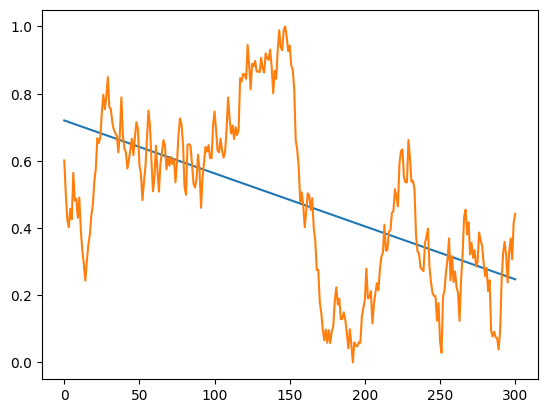

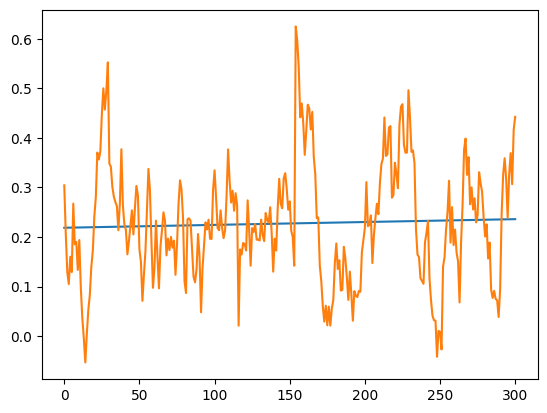

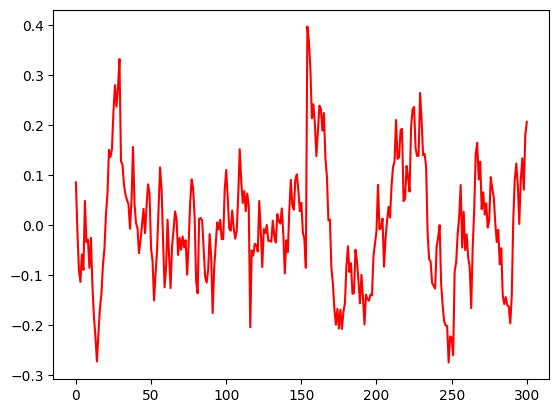

In [50]:

#from jump import FindJump
import numpy as np
import matplotlib.pyplot as plt
import stochastic.processes as sto 
fbm = sto.FractionalBrownianMotion()
ts = fbm.sample(300)
#ts = np.linspace(0,1,300)
#s = 2*np.ones(300)
#ts[:len(ts)//2] += 0.5 
findJump= TrendJumpTransform(ts,window_size=32)
ts = findJump.time_series
jfree=findJump.trend_jump_transform()
plt.figure("cc")
plt.plot(jfree,c='r')


# jumps=findJump.jump_detection()
# for key , val in jumps.items():
#     plt.scatter(x=key,y=val, c='r')
# plt.plot(findJump.time_series)
# plt.plot(findJump.fit_line(findJump.time_series))


In [10]:
import numpy as np
import pandas as pd


class FindJump:
    def __init__(self,
                time_series:np.ndarray,
                window_size:int = 16,
                ):
        self.time_series = self._normalize(time_series)
        self.window_size = window_size
        self.jumps = self.jump_detection() 
        self.jump_free_time_series,  self.heights = self.transform_jumps()
        
    @staticmethod    
    def rolling_mean_std(time_series: np.ndarray, span_window=10):
        ewm = pd.Series(time_series).ewm(span=span_window, adjust=False)
        mean = ewm.mean().iat[-1]
        std = ewm.std().bfill().iat[-1]
        return mean, std
    
    def jump_metric(self, current_price:float, last_mean:float,last_std:float) -> float:
        last_std = 0.00001 if last_std==0.0 else last_std
        dist = (current_price-last_mean)**2 / 2*last_std**2
        return dist
    
    def is_jump(self,time_series:np.ndarray, threshold_jump=1e-4) -> bool:
        # drop last data for mean and std
        last_mean, last_std = self.rolling_mean_std(time_series[:-1],self.window_size)
           
        dist=self.jump_metric(time_series[-1],last_mean,last_std)
        if dist > threshold_jump:
            return True
        else:
            return False
    @staticmethod
    def _normalize(time_series:np.ndarray) -> np.ndarray:
        time_series -= np.min(time_series)
        max_min = np.max(time_series) - np.min(time_series)
        max_min = max_min if max_min !=0 else 1
        time_series /= max_min
        return time_series

        
    def jump_detection(self) -> dict:
        jump_dict = {}
        time_series = self.time_series  
        window_size = self.window_size
        i = window_size
        while i < len(time_series):
            ts = time_series[i-window_size:i]
            if self.is_jump(ts):
                jump_dict[i] = ts[-1]
                i += window_size  # Shift i by window_size to skip
            else:
                i += 1  # Increment by 1 if no jump is detected
        return jump_dict

    def transform_jumps(self):
        index_jumps = list(self.jumps)
        time_series = self.time_series.copy()
        height_jumps = {} 
        for index_jump in index_jumps:
            back_index = 2 # is there any way to find the exact ? that's fine 
            mean_before_jump = np.mean(time_series[index_jump-self.window_size:index_jump-back_index])
            mean_after_jump = np.mean(time_series[index_jump:index_jump+self.window_size])
            height_jump = mean_after_jump - mean_before_jump 
            height_jumps[index_jump] =  height_jump
            time_series[:index_jump-back_index] += height_jump

        return time_series, height_jumps

    def inverse_jump_transform(self,free_jump_time_series):
        inv_ts = free_jump_time_series
        for index_jump, height_jump in self.heights.items():
            back_index = 2
            inv_ts[:index_jump-back_index] -= height_jump
        return inv_ts   

    
    @staticmethod
    def fit_line(data: np.ndarray) -> np.ndarray:
        """
        Fits a straight line to the given 1D time series data.
        """
        n = data.size
        x = np.arange(n)
        # Solve for the best fit line y = mx + b using least squares
        A = np.vstack([x, np.ones(n)]).T
        m, b = np.linalg.lstsq(A, data, rcond=None)[0]
        
        return np.array(m * x + b)

In [37]:
import numpy as np
import pandas as pd


class TrendTransform:
    def __init__(self,
                time_series:np.ndarray,
                ):
        self.time_series = time_series
        self.trend_line = self.fit_line(time_series)
        
    
    @staticmethod
    def fit_line(data: np.ndarray) -> np.ndarray:
        """
        Fits a straight line to the given 1D time series data.
        """
        n = data.size
        x = np.arange(n)
        # Solve for the best fit line y = mx + b using least squares
        A = np.vstack([x, np.ones(n)]).T
        m, b = np.linalg.lstsq(A, data, rcond=None)[0]
        
        return np.array(m * x + b)

class TrendJumpTransform:
    def __init__(self,
                 time_series:np.ndarray,
                 window_size:int=32
                 ):
        self.time_series = self._normalize(time_series)
        self.window_size = window_size
        
    @staticmethod    
    def _normalize(time_series:np.ndarray) -> np.ndarray:
        time_series -= np.min(time_series)
        max_min = np.max(time_series) - np.min(time_series)
        max_min = max_min if max_min !=0 else 1
        time_series /= max_min
        return time_series
    
    def trend_jump_transform(self):
        time_series = self.time_series.copy()
        jump_free_time_series = FindJump(time_series,self.window_size).jump_free_time_series
        jump_free_trend_line = TrendTransform(jump_free_time_series).trend_line
        jump_trend_free_time_series = jump_free_time_series - jump_free_trend_line
        plt.figure("aa")
        plt.plot(TrendTransform(time_series).trend_line)
        plt.plot(time_series)
        plt.figure("bb")
        plt.plot(jump_free_trend_line)
        plt.plot(jump_free_time_series)
        
        return jump_trend_free_time_series